# Data loading

In [1]:
import pandas as pd

In [2]:
DATA_IN = "../data/raw/rees46/"

In [3]:
def optimize_numeric_dtypes(df):
    import pandas as pd
    float_cols = df.select_dtypes("float").columns
    int_cols = df.select_dtypes("integer").columns
    df[float_cols] = df[float_cols].\
        apply(pd.to_numeric, downcast="float")
    df[int_cols] = df[int_cols].\
        apply(pd.to_numeric, downcast="integer")
    return df

def read_spark_dump(data_dir, sub_dir):
    import pandas as pd
    import glob
    data_dir = os.path.join(data_dir, sub_dir, "*.gz")
    return pd.concat([pd.read_csv(f) \
        for f in glob.glob(data_dir)]).reset_index(drop=True)        

In [4]:
products = read_spark_dump(DATA_IN, "products")
categories = read_spark_dump(DATA_IN, "categories")
events = read_spark_dump(DATA_IN, "events")
event_types = pd.DataFrame.from_dict({"event_type_id":[0,1,2],
    "event_type_name":["view","cart","purchase"]})

In [5]:
events["user_id"] = events["user_id"].astype("int")
events["product_id"] = events["product_id"].astype("int")
events["event_type_id"] = events["event_type_id"].astype("int")
events["event_time"] = pd.to_datetime(events["event_time"])
events = optimize_numeric_dtypes(events)
display(events.info())
display(events.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806685 entries, 0 to 1806684
Data columns (total 6 columns):
 #   Column         Dtype                               
---  ------         -----                               
 0   event_time     datetime64[ns, pytz.FixedOffset(60)]
 1   user_id        int16                               
 2   product_id     int32                               
 3   event_type_id  int8                                
 4   price          float32                             
 5   user_session   object                              
dtypes: datetime64[ns, pytz.FixedOffset(60)](1), float32(1), int16(1), int32(1), int8(1), object(1)
memory usage: 46.5+ MB


None

,event_time,user_id,product_id,event_type_id,price,user_session
0,2019-12-01 13:50:51+01:00,5940,9204,0,205.899994,0c074ec3-1693-4146-8585-ebd44e77bd32
1,2019-12-01 13:51:22+01:00,5940,9204,0,205.899994,0c074ec3-1693-4146-8585-ebd44e77bd32
2,2019-12-05 16:51:50+01:00,5940,25,0,319.589996,40283692-f928-450c-b82c-78bda07607f6


In [6]:
products["product_id"] = products["product_id"].astype("int")
products["category_id"] = products["category_id"].astype("int")
products = optimize_numeric_dtypes(products)
display(products.info())
display(products.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81586 entries, 0 to 81585
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product_id   81586 non-null  int32 
 1   category_id  81586 non-null  int16 
 2   brand        65003 non-null  object
dtypes: int16(1), int32(1), object(1)
memory usage: 1.1+ MB


None

,product_id,category_id,brand
0,2022,153,milavitsa
1,1383,26,nokia
2,14,0,apple


In [7]:
categories["category_id"] = categories["category_id"].astype("int")
categories = optimize_numeric_dtypes(categories)
display(categories.info())
display(categories.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    1065 non-null   int16 
 1   category_code  828 non-null    object
dtypes: int16(1), object(1)
memory usage: 10.5+ KB


None

,category_id,category_code
0,246,apparel.shoes.slipons
1,551,apparel.shoes
2,552,apparel.shoes


# Preliminary exploration

In [9]:
enc_event_types = pd.get_dummies(events["event_type_id"])
enc_event_types.columns = ["view", "cart", "purchase"]
events = pd.concat([events, enc_event_types], axis=1)
#events.drop("event_type_id", inplace=True, axis=1)
events["purchased_revenue"] = events.purchase*events.price
events["browsed_revenue"] = (1-events.purchase)*events.price

sessions = events.groupby("user_session", as_index=False).\
    agg(user_id=("user_id","min"), session_start=("event_time",min), session_end=("event_time",max),
        session_clics=("event_time","count"), session_views=("view","sum"), session_carts=("cart","sum"), session_purchases=("purchase","sum"),
        session_purchased_revenue=("purchased_revenue","sum"), session_browsed_revenue=("browsed_revenue","sum"))
sessions["is_purchase"] = sessions.session_purchased_revenue>0
sessions["is_abadoned"] = (~sessions["is_purchase"]) & (sessions["session_carts"]>0)

In [10]:
agg_sessions = sessions.groupby(sessions.session_start.dt.date).agg(session_count=("user_session","count"),
    abadoned_count=("is_abadoned","sum"), purchase_count=("is_purchase","sum"),revenue=("session_purchased_revenue","sum"))
agg_sessions["left_count"] = agg_sessions.session_count-(agg_sessions.abadoned_count+agg_sessions.purchase_count)
agg_sessions["avg_revenue"] =  agg_sessions.revenue/agg_sessions.purchase_count
agg_sessions["tocart_conversion_rate"] = (agg_sessions.abadoned_count+agg_sessions.purchase_count)/agg_sessions.session_count
agg_sessions["purchase_conversion_rate"] = agg_sessions.purchase_count/agg_sessions.session_count
agg_sessions.reset_index(inplace=True)
agg_sessions.head(3)

,session_start,session_count,abadoned_count,purchase_count,revenue,left_count,avg_revenue,tocart_conversion_rate,purchase_conversion_rate
0,2019-12-01,5757,453,2790,1402595.375,2514,502.722357,0.563314,0.484627
1,2019-12-02,6344,544,3045,1566854.125,2755,514.566215,0.565731,0.479981
2,2019-12-03,6672,674,3298,1507820.625,2700,457.192427,0.595324,0.494305


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

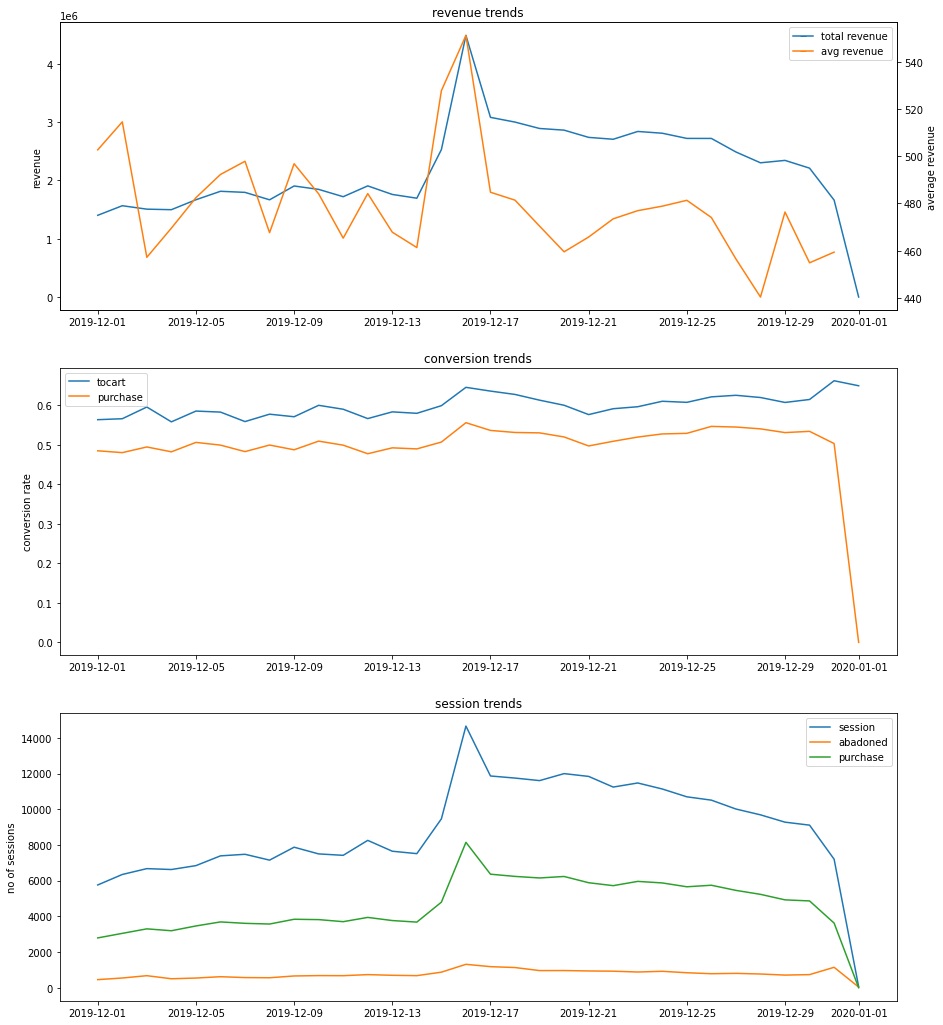

In [12]:
# dynamic
## sessions/events
    ## revenue, no of sessions, avg transaction size
    ## no of sessions, abadoned sessions, transaction sessions
    ## conversion rates
    
# revenue trends
fig, ax = plt.subplots(3,1,figsize=(15,18))
from matplotlib.lines import Line2D
palt = sns.color_palette()
_ = sns.lineplot(x="session_start", y="revenue",
    data=agg_sessions, color=palt[0],ax=ax[0]);
tax =_.axes.twinx()
sns.lineplot(x="session_start", y="avg_revenue",
    data=agg_sessions, color=palt[1], ax=tax);
_.legend(handles=[Line2D([], [], marker="_", color=palt[0], label="total revenue"),
    Line2D([], [], marker="_", color=palt[1], label="avg revenue")])
ax[0].set_ylabel("revenue");
tax.set_ylabel("average revenue")
ax[0].set_xlabel("");
ax[0].set_title("revenue trends");

# session trends
agg_ses_melted = pd.melt(agg_sessions,"session_start",
    ["tocart_conversion_rate", "purchase_conversion_rate"])
agg_ses_melted["variable"] = agg_ses_melted["variable"].\
    apply(lambda x: x.split("_")[0])    

sns.lineplot(x="session_start", y="value",
    hue="variable", data=agg_ses_melted, ax=ax[1])
ax[1].set_ylabel("conversion rate");
ax[1].set_xlabel("");
ax[1].set_title("conversion trends");
ax[1].get_legend().set_title("");
del agg_ses_melted;

# conversion rate trends
agg_ses_melted = pd.melt(agg_sessions,"session_start",
    ["session_count", "abadoned_count", "purchase_count"])
agg_ses_melted["variable"] = agg_ses_melted["variable"].\
    apply(lambda x: x.split("_")[0])    

sns.lineplot(x="session_start", y="value",
    hue="variable", data=agg_ses_melted, ax=ax[2])
ax[2].set_ylabel("no of sessions");
ax[2].set_xlabel("");
ax[2].set_title("session trends");
ax[2].get_legend().set_title("");
del agg_ses_melted;

In [13]:

## users
    # dynamic
        ## no of active users, no of transact users, propensity to buy

    # static
        ## intersession time, no of sessions, browsed revenue
        ## interpurchase time, no of transactions, purchased revenue
        ## account maturity

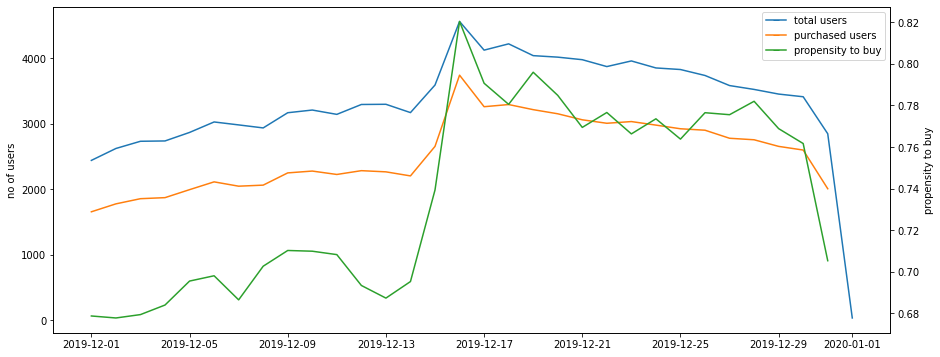

In [14]:
agg_users = pd.concat([sessions.groupby(sessions.session_start.dt.date).\
    agg(no_users=("user_id","nunique")), sessions[sessions.is_purchase].\
        groupby(sessions[sessions.is_purchase].session_start.dt.date).\
            agg(no_purch_users=("user_id","nunique"))], axis=1).reset_index()
agg_users["propensity_to_purchase"] = agg_users.no_purch_users/agg_users.no_users

# changes over time
fig, ax = plt.subplots(1,1,figsize=(15,6))
_ = sns.lineplot(x="session_start", y="value", hue="variable",
    data=pd.melt(agg_users, id_vars="session_start",
    value_vars=["no_users", "no_purch_users"]), ax=ax);
ax.set_xlabel("");
ax.set_ylabel("no of users");
tax =_.axes.twinx()
palt = sns.color_palette()
sns.lineplot(x="session_start", y="value",
    data=pd.melt(agg_users, id_vars="session_start",
    value_vars=["propensity_to_purchase"]),color=palt[2], ax=tax);
tax.set_ylabel("propensity to buy");
_.legend(handles=[Line2D([], [], marker="_", color=palt[0], label="total users"),
    Line2D([], [], marker="_", color=palt[1], label="purchased users"),
    Line2D([], [], marker="_", color=palt[2], label="propensity to buy")]);
del agg_users;

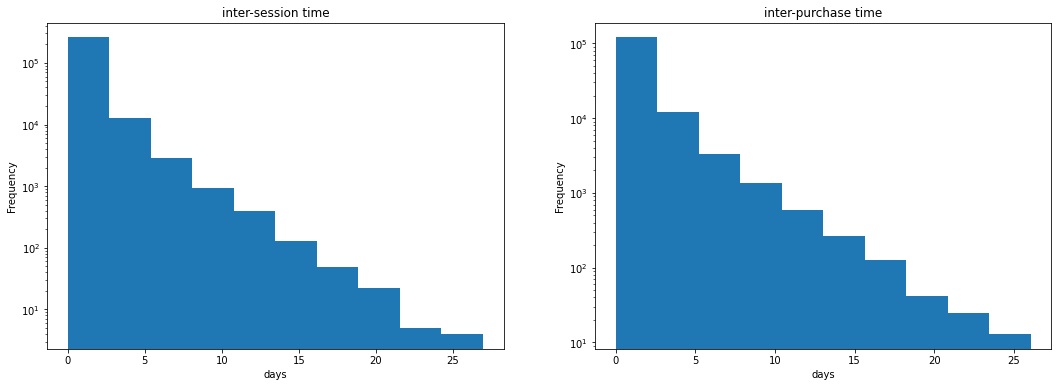

In [15]:
# recency in sessions and transactions
sessions = sessions.sort_values("session_start")
purch_sessions =  sessions[sessions.is_purchase].copy()
purch_sessions["prev_purchase_start"] = purch_sessions.groupby("user_id", as_index=False).\
    session_start.shift()
purch_sessions["inter_purchase_time"] = purch_sessions.session_start-purch_sessions.prev_purchase_start
sessions = sessions.merge(purch_sessions[["prev_purchase_start","inter_purchase_time"]],
    how="left", left_index=True, right_index=True)

sessions["prev_session_start"] = sessions.groupby("user_id", as_index=False).session_start.shift()
sessions["inter_session_time"] = sessions.session_start-sessions.prev_session_start

fig, ax = plt.subplots(1,2,figsize=(18,6))
(sessions["inter_session_time"].dt.total_seconds()/(24*3600)).\
    plot(kind="hist", logy=True, ax=ax[0]);
ax[0].set_xlabel("days");
ax[0].set_title("inter session time");

(sessions["inter_purchase_time"].dt.total_seconds()/(24*3600)).\
    plot(kind="hist", logy=True, ax=ax[1]);
ax[1].set_xlabel("days");
ax[1].set_title("inter purchase time");

In [ ]:
# frequency in sessions and transactions


In [ ]:
# monetary in sessions and transactions

In [ ]:
# monthly revenue per user

# cumulative monthly revenue per user

# diff in cumulative monthly revenue per user

In [ ]:
# categories and products
    ## revenue, views, conversion rate
    ## show top and bottom 10

# category 
    ## revenue, views, conversion rate
    ## show top and bottom 10